# Semi-Supervised Learning for Sentiment Analysis

# Library Imports

In [18]:
# basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# preprocessing
from sklearn.model_selection import train_test_split # train-test-split
from sklearn.feature_extraction.text import TfidfVectorizer # vectorizer

# model
from sklearn.linear_model import LogisticRegression
from sklearn.semi_supervised import SelfTrainingClassifier

# metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Data Loading

In [2]:
df = pd.read_csv("DisneylandReviews.csv", encoding = 'latin-1')
df.head()

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch
0,670772142,4,2019-4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong
1,670682799,4,2019-5,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong
2,670623270,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong
3,670607911,4,2019-4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong
4,670607296,4,2019-4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong


In [3]:
# text data
X = df['Review_Text']

# labeled data
y = df['Rating']

# Preprocessing

In [4]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 42
)

In [5]:
# vectorize text input
vectorizer = TfidfVectorizer(max_features = 5000)
X_train_vec = vectorizer.fit_transform(X_train) # fit on training data, then transform
X_test_vec = vectorizer.transform(X_test) # ONLY transform testing data

# Semi-Supervised Learning Model

For semi-supervised learning, our model learns to leverage both unlabeled and (very few) labeled data together in order to perform a classification task.

In our example, we use a standard classifier first (e.g. Logistic Regression) on the labeled data. Afterwards, this classifier predicts labels for the unlabeled data; the most confident predictions to the labeled set (a process called **pseudo-labeling**). this process is repeated until no more samples can be confidently labeled, or until a max-iteration threshold has been reached.

In [6]:
# since all of our data is currently labeled, let's hide some labels
# suppose we only have 20% of the total labels available for us to use

# seed
rng = np.random.RandomState(42)
mask = rng.rand(len(y_train)) < 0.8 # hide 80% of data
y_train_semi = y_train.copy() # make copy of original labels
y_train_semi[mask] = -1 # apply mask; unlabeled = -1 for sklearn

In [8]:
# create base classifier
base_clf = LogisticRegression(max_iter = 1000)

In [9]:
# semi-supervised learning: self-training classification
self_training_clf = SelfTrainingClassifier(base_clf) 
self_training_clf.fit(X_train_vec, y_train_semi) # train semi-supervised classifier on full text data, limited rating labels

,estimator,LogisticRegre...max_iter=1000)
,base_estimator,'deprecated'
,threshold,0.75
,criterion,'threshold'
,k_best,10
,max_iter,10
,verbose,False
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0


## Evaluation

In [ ]:
# evaluate performance
y_pred = self_training_clf.predict(X_test_vec)
print(classification_report(y_test, y_pred)) # compare full testing labels with SSL pseudo-labeing

              precision    recall  f1-score   support

           1       0.65      0.06      0.11       292
           2       0.36      0.05      0.08       428
           3       0.38      0.12      0.18      1035
           4       0.37      0.10      0.15      2200
           5       0.59      0.97      0.74      4577

    accuracy                           0.57      8532
   macro avg       0.47      0.26      0.25      8532
weighted avg       0.50      0.57      0.46      8532



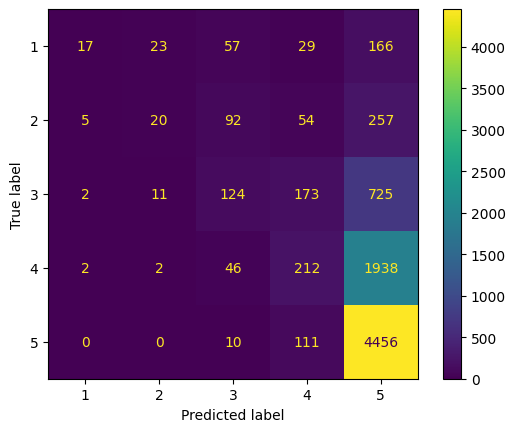

In [19]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                              display_labels = [1, 2, 3, 4, 5])
disp.plot()
plt.show()